# Distribution of swept regions and enrichments in sweeps

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [6]:
import analysis_globals

## Convenience functions

In [7]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1, x
    return x[0]

from multiprocessing import Pool, cpu_count

# def cpu_count():
#     return int(os.environ['SLURM_CPUS_PER_TASK'])

def parallel_apply(grouped, func, *args, chunksize=None):
    names, groups = zip(*grouped)
    arg_iter = zip(groups, *[[x]*len(groups) for x in args])
    
    slurm_cores = os.environ.get('SLURM_JOB_NUM_NODES')
    nr_cpu = slurm_cores and int(slurm_cores) or cpu_count()

    with Pool(nr_cpu) as p:
        l = p.starmap(func, arg_iter, chunksize=chunksize)
        
    df = pandas.concat(l, keys=names)
    df.reset_index(level=df.index.nlevels-1, drop=True, inplace=True)
    return df

## Load meta data

In [8]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Separate region legends for plots

In [37]:
fig = plt.figure()
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend1column.pdf'))
plt.close()

In [38]:
fig = plt.figure(figsize=(10,2))
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left', ncol=7)
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend7column.pdf'))
plt.close()

In [39]:
fig = plt.figure(figsize=(10,2))
plt.axis('off')
ax = plt.gca()
legend_elements = [Line2D([0], [0], marker='o', color='white', markersize=10, 
                          label=reg, markerfacecolor=region_colors[reg]) for reg in region_categories]
ax.legend(handles=legend_elements, loc='lower left', ncol=3)
plt.tight_layout()
plt.savefig(str(figures_dir / 'legend3column.pdf'))
plt.close()

## Load pairwise distance data

Load pairwise distances for all male individuals:

In [10]:
all_male_dist_twice = pandas.read_hdf(results_dir / 'all_male_dist_twice.hdf')
all_male_dist_twice_1Mb = pandas.read_hdf(results_dir / 'all_male_dist_twice_1Mb.hdf')

## Call sweeps

- Running window of five 100kb windows.
- Compute clade size of each from mean dist across the five windows.
- If the 500kb window is called as sweep, then each constituent 100kb window is called as swept.


In [10]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

Call 500kb rolling windows as swept or not. We do nonoverlapping 500kb windows in five 100kb offsets.

In [ ]:
def call_rolling_windows(df):#, pwdist_cutoff, min_sweep_clade_size):
    """
    Takes a df with all pwdiffs in a 500kb rolling window between 
    one indiv and all other individuals. Returns all nan if one or more 100kb 
    windows are without any data. Computes mean pwdist across 
    the five 100kb windows between each pair. Calls sweep_clade as number 
    of other indivisuals with a pwdist smaller than cutoff. Calls as
    swept if this number is above cutoff. Computes mean_clade_dist as 
    mean pwdist in sweep clade.
    """
    
    def mean_indiv_dist(df, col):
        """
        Compute mean across 100kb windows in in 500kb window.
        """
        if len(df) != nr_wins:
            return numpy.nan
        return df[col].mean()
    
    if numpy.isnan(df.groupby('start')['dist'].mean()).any():
        # one or more 100kb has no dist data
        called, clade_size, mean_clade_dist = numpy.nan, numpy.nan, numpy.nan
    else:
        # mean distance between indiv_1 and each indiv_2 for the 500kb window
        pwdiffs = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist')

        mean_clade_dist = pwdiffs.loc[pwdiffs <= analysis_globals.pwdist_cutoff].mean() 
        
        # number of indiv_2 closer to indiv_1 than cutoff across the 500kb window
        clade_size = (pwdiffs <= analysis_globals.pwdist_cutoff).sum() 
        
        # call if clade size is larger then cutoff
        called = clade_size >= analysis_globals.min_sweep_clade_size
    
    if numpy.isnan(df.groupby('start')['dist_af'].mean()).any():     
        called_af, clade_size_af, mean_clade_dist_af = numpy.nan, numpy.nan, numpy.nan
    else:
        pwdiffs_af = df.groupby(['indiv_2']).apply(mean_indiv_dist, 'dist_af')

        mean_clade_dist_af = pwdiffs.loc[pwdiffs_af <= analysis_globals.pwdist_cutoff].mean() 

        clade_size_af = (pwdiffs_af <= analysis_globals.pwdist_cutoff).sum()

        called_af = clade_size_af >= analysis_globals.min_sweep_clade_size

    return df.copy().assign(called=called, clade_size=clade_size, mean_clade_dist=mean_clade_dist,
                            called_af=called_af, clade_size_af=clade_size_af, mean_clade_dist_af=mean_clade_dist_af)




In [ ]:
nr_wins = 5
offsets = [x * 100000 for x in range(nr_wins)]
window_size = len(offsets) * 100000

from multiprocessing import Pool, cpu_count

#nr_cpu = int(os.environ.get('SLURM_JOB_NUM_NODES'))

lst = list()
# loop over five offsets of 500kb windows
for off in offsets:
    with Timer():
        print(off)
        groups = (all_male_dist_twice
                  .assign(off=off, # keep offset
                          roll_win = lambda df: (off + df.start) // window_size) # label for rolling 500kb window
                 .groupby(['indiv_1', 'roll_win', 'off'])
                 )
        with Pool(nr_cpu) as p:
            df = pandas.concat(p.map(call_rolling_windows, [group for name, group in groups]))

#        df = pandas.concat([call_rolling_windows(group) for name, group in groups])
            
        lst.append(df)

Concat sweep running window calls for each offset and label a 100kb window as `called` if it is part of a sweep in any offset.

In [23]:
def call_swept(df):
    """
    Takes a df with all rolling window data for an indivisual for one 100kb window.
    Call each 100kb window as sweept if any overlapping rolling window is called as swept.
    Compute clade size and mean clade dist as from the rolling window with the largest clade size.
    """
    max_clade_size = df.clade_size.max()
    max_clade_size_af = df.clade_size_af.max()
    
    largest_clade_offsets = (df.groupby('off')
                             .filter(lambda df: (df.clade_size == max_clade_size).all() and df.called.all())
                            )
    largest_clade_offsets_af = (df.groupby('off')
                             .filter(lambda df: (df.clade_size_af == max_clade_size_af).all() and df.called_af.all())
                            )
    return DataFrame(dict(called=[df.called.any()], 
                          clade_size=[max_clade_size],
                          clade_mean_dist=[largest_clade_offsets['dist'].mean()],
                          called_af=[df.called_af.any()], 
                          clade_size_af=[max_clade_size_af],
                          clade_mean_dist_af=[largest_clade_offsets_af['dist_af'].mean()]))

with Timer():
    sweep_calls = (pandas.concat(lst)
                   .groupby(['indiv_1', 'start'])
                   .apply(call_swept)
                   .reset_index(level=['indiv_1', 'start'])
                  )

38 min 59.5 sec


In [24]:
sweep_calls.head(3)

indiv_1   start  called  called_af  clade_mean_dist  \
0  B_Australian-4       0   False      False              NaN   
0  B_Australian-4  100000   False      False              NaN   
0  B_Australian-4  200000   False      False              NaN   
0  B_Australian-4  300000   False      False              NaN   
0  B_Australian-4  400000   False      False              NaN   

   clade_mean_dist_af  clade_size  clade_size_af  
0                 NaN         NaN            NaN  
0                 NaN         NaN            NaN  
0                 NaN         NaN            NaN  
0                 NaN         NaN            NaN  
0                 NaN         NaN            NaN

Delete list of gigantic dataframes:

In [25]:
del lst

Compute stats for each window:

In [26]:
def window_stats(df):
    return pandas.DataFrame({
                             'mean_dist': [df.dist.mean()],
                             'mean_dist_to_africans': [df.loc[df.region_2 == 'Africa', 'dist'].mean()],
                             'mean_dist_af': [df.dist_af.mean()],
                             'mean_dist_to_africans_af': [df.loc[df.region_2 == 'Africa', 'dist_af'].mean()],
                             'win_swept': (df.dist <= analysis_globals.pwdist_cutoff).sum() >= \
                                               analysis_globals.min_sweep_clade_size,
                             'win_swept_af': (df.dist_af <= analysis_globals.pwdist_cutoff).sum() >= 
                                               analysis_globals.min_sweep_clade_size,
                             'prop_indivs_missing': [numpy.isnan(df.dist).sum() / df.dist.size]
                             })

In [27]:
# gr_cols = ['indiv_1', 'start', 'end', 'pop_1', 'region_label_1', 'region_id_1', 'region_1']
# groups = all_male_dist_twice.groupby(gr_cols)
# with Pool(nr_cpu) as p:
#     df = pandas.concat(p.map(window_stats, [group for name, group in groups]))
# df.head()

In [30]:
with Timer():
    gr_cols = ['indiv_1', 'start', 'end', 'pop_1', 'region_label_1', 'region_id_1', 'region_1']
    df = (all_male_dist_twice
          .groupby(gr_cols)
          .apply(window_stats)
          .reset_index(level=gr_cols)
         )

9 min 19.8 sec


In [32]:
df.head(3)

indiv_1   start     end       pop_1 region_label_1  region_id_1  \
0  B_Australian-4       0  100000  Australian        Oceania            4   
0  B_Australian-4  100000  200000  Australian        Oceania            4   
0  B_Australian-4  200000  300000  Australian        Oceania            4   
0  B_Australian-4  300000  400000  Australian        Oceania            4   
0  B_Australian-4  400000  500000  Australian        Oceania            4   

  region_1  mean_dist  mean_dist_af  mean_dist_to_africans  \
0  Oceania        NaN           NaN                    NaN   
0  Oceania        NaN           NaN                    NaN   
0  Oceania        NaN           NaN                    NaN   
0  Oceania        NaN           NaN                    NaN   
0  Oceania        NaN           NaN                    NaN   

   mean_dist_to_africans_af  prop_indivs_missing  win_swept  win_swept_af  
0                       NaN                  1.0      False         False  
0                       NaN                  1.0      False         False  
0                       NaN                  1.0      False         False  
0                       NaN                  1.0      False         False  
0                       NaN                  1.0      False         False

In [33]:
sweep_data = df.merge(sweep_calls, on=['indiv_1', 'start'])

Get run length windows labelled as `called`, and assign windows as `swept` if they are part of a run of at least the cutoff specified:

In [35]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

sweep_data['run_id'] = (sweep_data
                        .groupby('indiv_1')['called']
                        .apply(run_id)
                       )
sweep_data['run_length'] = (sweep_data
                            .groupby(['indiv_1', 'run_id'])['run_id']
                            .transform(numpy.size)
                           )
sweep_data['swept'] = numpy.bitwise_and(sweep_data['called'], 
                                        sweep_data['run_length'] >= analysis_globals.min_run_length)

sweep_data['run_id_af'] = (sweep_data
                        .groupby('indiv_1')['called_af']
                        .apply(run_id)
                       )
sweep_data['run_length_af'] = (sweep_data
                            .groupby(['indiv_1', 'run_id_af'])['run_id_af']
                            .transform(numpy.size)
                           )
sweep_data['swept_af'] = numpy.bitwise_and(sweep_data['called_af'], 
                                        sweep_data['run_length_af'] >= analysis_globals.min_run_length)

In [36]:
sweep_data.head(3)

indiv_1   start     end       pop_1 region_label_1  region_id_1  \
0  B_Australian-4       0  100000  Australian        Oceania            4   
1  B_Australian-4  100000  200000  Australian        Oceania            4   
2  B_Australian-4  200000  300000  Australian        Oceania            4   
3  B_Australian-4  300000  400000  Australian        Oceania            4   
4  B_Australian-4  400000  500000  Australian        Oceania            4   

  region_1  mean_dist  mean_dist_af  mean_dist_to_africans    ...     \
0  Oceania        NaN           NaN                    NaN    ...      
1  Oceania        NaN           NaN                    NaN    ...      
2  Oceania        NaN           NaN                    NaN    ...      
3  Oceania        NaN           NaN                    NaN    ...      
4  Oceania        NaN           NaN                    NaN    ...      

   clade_mean_dist  clade_mean_dist_af  clade_size  clade_size_af  run_id  \
0              NaN                 NaN         NaN            NaN       1   
1              NaN                 NaN         NaN            NaN       1   
2              NaN                 NaN         NaN            NaN       1   
3              NaN                 NaN         NaN            NaN       1   
4              NaN                 NaN         NaN            NaN       1   

   run_length  swept  run_id_af  run_length_af  swept_af  
0         111  False          1            111     False  
1         111  False          1            111     False  
2         111  False          1            111     False  
3         111  False          1            111     False  
4         111  False          1            111     False  

[5 rows x 26 columns]

## Distributions of dist between haplotypes

The mean distance to other individuals in the sweep clade for each swept individual:

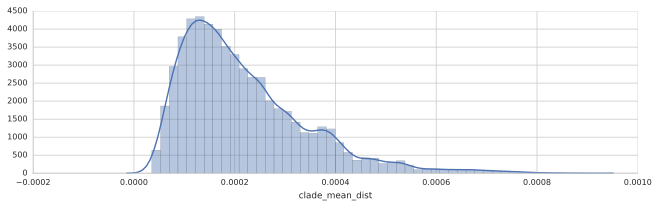

In [37]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=sweep_data, #hue='swept', 
                      aspect=3)
    g = g.map(sns.distplot, 'clade_mean_dist')
    g = g.add_legend()

The mean distance to all other individuals for each swept individual:

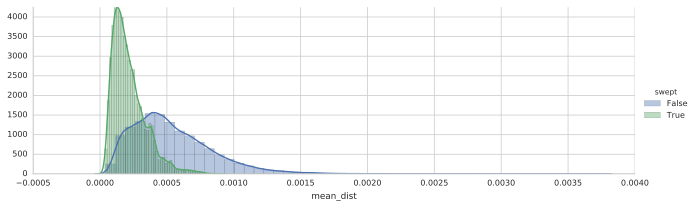

In [38]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=sweep_data, hue='swept', aspect=3)
    g = g.map(sns.distplot, 'mean_dist')
    g = g.add_legend()

## Windows where distances to other individuals are incompletely known

100kb windows:

In [39]:
print('Max proportion of uncalled individuals:', analysis_globals.max_prop_indiv_missing)

Max proportion of uncalled individuals: 0.1


In [40]:
sweep_data.prop_indivs_missing.describe()

count    251424.000000
mean          0.109371
std           0.310451
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: prop_indivs_missing, dtype: float64

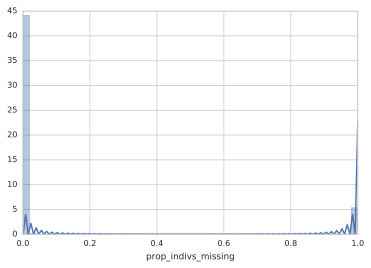

In [41]:
g = sns.distplot(sweep_data.prop_indivs_missing)

In [42]:
missing_indiv_window_mask = sweep_data.prop_indivs_missing <= analysis_globals.max_prop_indiv_missing
print('Proportion of 100kb windows left after filtering:', missing_indiv_window_mask.sum() / missing_indiv_window_mask.size)

sweep_data['not_missing'] = missing_indiv_window_mask

Proportion of 100kb windows left after filtering: 0.888892866234


## Pi for entire chrom and when excluding haplotypes called as swept

In [41]:
#all_male_dist_twice = pandas.read_hdf(analysis_globals.results_dir / 'all_male_dist_twice.hdf')

In [12]:
#sweep_data = pandas.read_hdf(analysis_globals.results_dir / 'sweep_data.hdf')

In [16]:
df = (all_male_dist_twice
      .loc[(all_male_dist_twice.region_label_1 != 'Africa') & (all_male_dist_twice.region_label_2 != 'Africa'),
          ['start', 'indiv_1', 'indiv_2', 'dist']]
      .merge(sweep_data[['start', 'indiv_1', 'swept']], on=['start', 'indiv_1'], how='left')
     )

In [26]:
(df.loc[df.swept != True].dist.mean(), 
 df.dist.mean(), 
    df.loc[df.swept == True].dist.mean() / df.dist.mean(), 
    df.dist.mean() / df.loc[df.swept != True].dist.mean()
    )

(0.0004672873995445759,
 0.00043342700449411321,
 0.38242038135039763,
 0.92753839482198008)

It seems pi only increases a little when sweept haplotypes are removed. Which makes sense if their average diversity is 38% of global average and since they only account for a relatively small part of all haplotypes.

## Proportion of missing windows across chromosome

In [20]:
#sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [21]:
missing_windows = (sweep_data
                            .groupby(['start', 'end'])['prop_indivs_missing']
                            .mean()
                            .reset_index()
                            .rename(columns={'prop_indivs_missing': 'mean_prop_indivs_missing'})
                           )
missing_windows['is_missing'] = missing_windows.mean_prop_indivs_missing >= analysis_globals.max_prop_indiv_missing

Write missing windows to hdf:

In [22]:
missing_windows.to_hdf(results_dir / 'missing_windows.hdf', 'df', format='table', mode='w')
missing_windows.head()

start     end  mean_prop_indivs_missing  is_missing
0       0  100000                       1.0        True
1  100000  200000                       1.0        True
2  200000  300000                       1.0        True
3  300000  400000                       1.0        True
4  400000  500000                       1.0        True

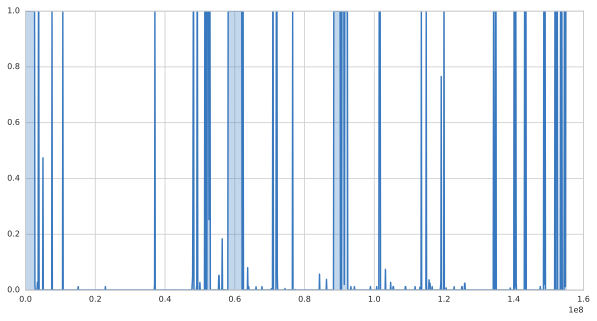

In [23]:
with sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"]):
    fig, ax = plt.subplots(figsize=(10, 5))
    g = ax.plot(missing_windows.start, missing_windows.mean_prop_indivs_missing)
    g = ax.fill_between(missing_windows.start, missing_windows.mean_prop_indivs_missing, alpha=0.3)

In [26]:
tot_missing = (missing_windows
 .loc[sweep_data.swept==True, ['start', 'end']]
 .drop_duplicates()
 .assign(length=lambda df: df.end-df.start)
 .length.sum()
)
tot_missing

12300000

## How much of chromosome is covered by ECHs?

In [25]:
tot_covered = (sweep_data
 .loc[sweep_data.swept==True, ['start', 'end']]
 .drop_duplicates()
 .assign(length=lambda df: df.end-df.start)
 .length.sum()
)
tot_covered, tot_covered / 155270560, tot_covered / (155270560 - tot_missing)

(45600000, 0.29368091414109665, 0.31894678177101637)

## Consequtive regions with missing data

Run id for windows with missing/non-missing status:

In [13]:
def run_id(sr):
    return (sr != sr.shift()).cumsum()

missing_windows['missing_status_run_id'] = run_id(missing_windows.is_missing)

For each individual compute how big a run of non-missing windows that window is part of:

In [14]:
missing_windows['missing_status_run_length'] = (missing_windows
                                 .groupby(['missing_status_run_id'])['missing_status_run_id']
                                 .transform(numpy.size)
                                )
missing_windows.head()

start     end  mean_prop_indivs_missing  is_missing  \
0       0  100000                       1.0        True   
1  100000  200000                       1.0        True   
2  200000  300000                       1.0        True   
3  300000  400000                       1.0        True   
4  400000  500000                       1.0        True   

   missing_status_run_id  missing_status_run_length  
0                      1                         27  
1                      1                         27  
2                      1                         27  
3                      1                         27  
4                      1                         27

Get start end coordinates of each region:

In [15]:
missing_regions = (missing_windows
                   .groupby(['missing_status_run_id', 'is_missing'])
                   .aggregate({'start': 'min', 'end': 'max'})
                   .reset_index()
                  )
missing_regions.head()

missing_status_run_id  is_missing      end    start
0                      1        True  2700000        0
1                      2       False  3700000  2700000
2                      3        True  3900000  3700000
3                      4       False  5000000  3900000
4                      5        True  5100000  5000000

In [16]:
missing_regions.to_hdf(results_dir / 'missing_regions.hdf', 'df', format='table', mode='w')

## Proportion of swept sequence in each non-African individual

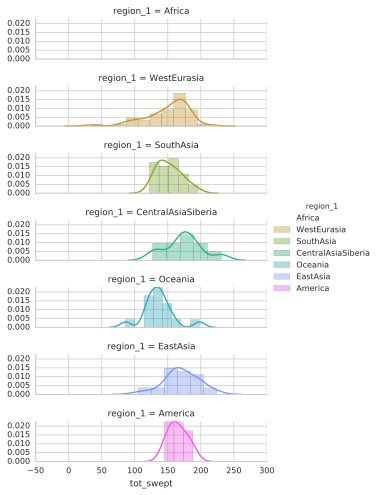

In [51]:
plot_df = (sweep_data
           .loc[lambda df: df.region_1 != 'Africa']
           .groupby(['indiv_1', 'region_1'])['swept']
           .agg('sum')
           .to_frame('tot_swept')
           .reset_index()
          )

with sns.color_palette('Set1'):
    g = sns.FacetGrid(plot_df, hue="region_1", row='region_1', legend_out=True, size=1, aspect=4)
    g = g.map(sns.distplot, "tot_swept")
    g.add_legend()

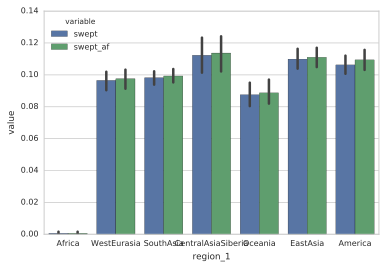

In [52]:
df = (sweep_data[['indiv_1', 'region_1', 'swept', 'swept_af']]
           .groupby(['indiv_1', 'region_1'])
           .mean()
           .reset_index()
           .loc[lambda df: (~numpy.isnan(df.swept))]
          )
plot_df = pandas.melt(df, id_vars=['indiv_1', 'region_1'], value_vars=['swept', 'swept_af'])

g = sns.barplot(data=plot_df, x='region_1', y='value', hue='variable', 
               order=sweep_data.region_1.cat.categories.values)

plt.savefig(str(figures_dir / 'prop_swept_by_region.pdf'))
plt.savefig(str(figures_dir / 'prop_swept_by_region.png'))

## Impact of missing data on sweep calling

To what extent is missing data responsible for what we call as swept.

It is possible that some regions of the chromsome are without sweeps simply because these regions have more missing data, so a run of sweep clade windows cannot be called. 

In [53]:
plot_df = (sweep_data[['start', 'end', 'swept']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
        )
plot_df.head()

start     end  swept  is_missing  missing_status_run_length
0       0  100000  False        True                         27
1  100000  200000  False        True                         27
2  200000  300000  False        True                         27
3  300000  400000  False        True                         27
4  400000  500000  False        True                         27

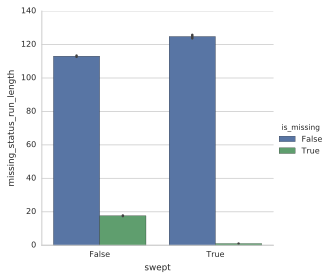

In [54]:
g = sns.factorplot(x='swept', y='missing_status_run_length', hue='is_missing', kind='bar', data=plot_df)

Windows called as swept are part of longer consequeitvely called regions than windows not called as swept. 
That could simply be becuase we demand that swept regions are always at least 500kb.

A better way to address the impact of missing data on the distribuion of swept windows across the chromosome, would be to see if windows called as `sweep_clade` are more often in non-missing regions larger than 500kb:

In [55]:

plot_df = (sweep_data[['start', 'end', 'win_swept']]#'sweep_clade']]
           .merge(missing_windows[['start', 'end', 'is_missing', 'missing_status_run_length']], 
                  on=['start', 'end'], how='left')
#           .loc[lambda df: df.is_missing == False]
           .assign(above_length_thresh = lambda df: df.missing_status_run_length >= analysis_globals.min_run_length)
        )
plot_df.head()


start     end  win_swept  is_missing  missing_status_run_length  \
0       0  100000      False        True                         27   
1  100000  200000      False        True                         27   
2  200000  300000      False        True                         27   
3  300000  400000      False        True                         27   
4  400000  500000      False        True                         27   

   above_length_thresh  
0                 True  
1                 True  
2                 True  
3                 True  
4                 True

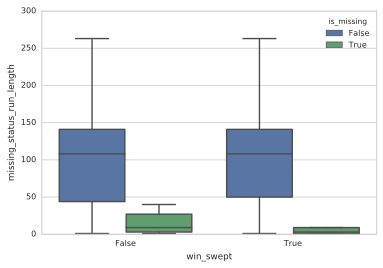

In [56]:
#sns.boxplot(x="sweep_clade", y="missing_status_run_length", hue='is_missing', data=plot_df)
sns.boxplot(x="win_swept", y="missing_status_run_length", hue='is_missing', data=plot_df)

It does seem that the run length of non-missing windows is not smaller for windows that are not in a sweep clade. In addition the mean length of non-missing regions is larger than 100, I.e. *much* larger than 5 (500kb)

## Make set that is not swept in any individual

In [57]:
#sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [58]:
sweep_data['never_swept'] = sweep_data.groupby('start')['swept'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_swept_af'] = sweep_data.groupby('start')['swept_af'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_win_swept'] = sweep_data.groupby('start')['win_swept'].transform(lambda sr: sr.sum() == 0)
sweep_data['never_win_swept_af'] = sweep_data.groupby('start')['win_swept_af'].transform(lambda sr: sr.sum() == 0)

## Split distribution of distances into regions with no sweept and regions with at least some swept

In [47]:
df = (all_male_dist_twice
      .loc[(all_male_dist_twice.region_label_1 != 'Africa') & (all_male_dist_twice.region_label_2 != 'Africa'),
          ['start', 'indiv_1', 'indiv_2', 'dist']]
      .merge(sweep_data[['start', 'indiv_1', 'swept', 'never_swept']], on=['start', 'indiv_1'], how='left')
     )

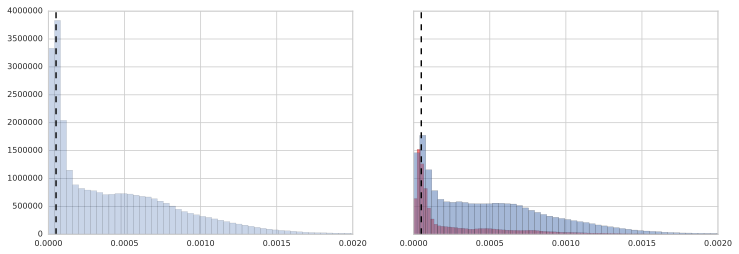

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

ax1.hist(df.dist.loc[~df.dist.isnull()], bins=100, alpha=0.3)

ax2.hist(df.dist.loc[~df.dist.isnull() & (df.never_swept == False)], bins=100, alpha=0.5, color='red')
ax2.hist(df.dist.loc[~df.dist.isnull() & (df.never_swept == True)], bins=100, alpha=0.5) ;

for ax in fig.axes:
    plt.sca(ax)
    plt.xlim(0, 0.002)
    plt.axvline(5e-5, color='black', linestyle='dashed')
#    plt.xticks(rotation=90)

## Make a set of conservatively swept and non-swept haplotypes

In [59]:
sweep_data['conserv_swept_group'] = [x and 'yes' or 'no' for x in sweep_data['swept']]
sweep_data['conserv_swept_group'].where(sweep_data['swept'] == sweep_data['win_swept'], 'ambig', inplace=True)
sweep_data['conserv_swept_group'].where(sweep_data.not_missing == True, 'ambig', inplace=True)

sweep_data['conserv_swept_group_af'] = [x and 'yes' or 'no' for x in sweep_data['swept_af']]
sweep_data['conserv_swept_group_af'].where(sweep_data['swept_af'] == sweep_data['win_swept_af'], 'ambig', inplace=True)
sweep_data['conserv_swept_group_af'].where(sweep_data.not_missing == True, 'ambig', inplace=True)

In [60]:
sweep_data.conserv_swept_group.value_counts()

no       178470
ambig     56266
yes       16688
Name: conserv_swept_group, dtype: int64

## Find all windows with both reliably swept and non-swept haplotypes

In [61]:
sweep_data['partial_sweep_win'] = sweep_data.groupby('start')['conserv_swept_group'].transform(lambda sr: (sr == 'yes').sum() > 0 and (sr == 'no').sum() > 0)
sweep_data['partial_sweep_win_af'] = sweep_data.groupby('start')['conserv_swept_group_af'].transform(lambda sr: (sr == 'yes').sum() > 0 and (sr == 'no').sum() > 0)

In [62]:
tmrca_stats = pandas.read_hdf(str(results_dir / 'pruned_tmrca_stats.hdf'))#.loc[lambda df: df.region == 'World']

In [63]:
plot_df = sweep_data.merge(tmrca_stats[['start', 'end', 'tmrca', 'tmrca_half', 'rel_tmrca_half']],
                           on=['start', 'end'],
                           how='left')

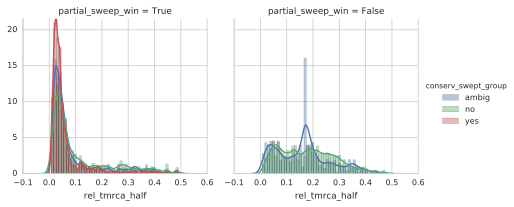

In [64]:
g = sns.FacetGrid(plot_df, col="partial_sweep_win",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

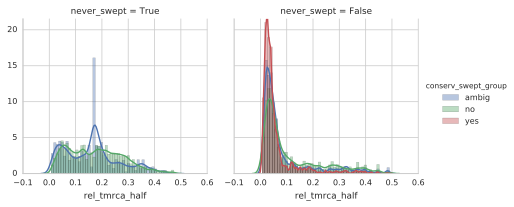

In [65]:
g = sns.FacetGrid(plot_df, col="never_swept",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

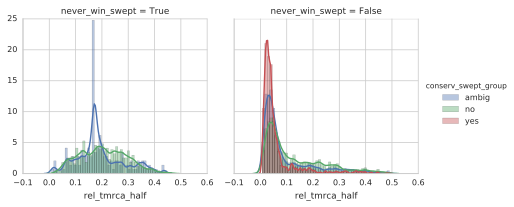

In [66]:
g = sns.FacetGrid(plot_df, col="never_win_swept",  hue="conserv_swept_group", col_order=[True, False])
g = g.map(sns.distplot, "rel_tmrca_half")
g = g.add_legend()

## Proportion of missing windows among swept and never swept

Missing among swept:

In [67]:
numpy.bitwise_and(sweep_data.swept, ~sweep_data.not_missing).sum() / sweep_data.swept.sum()

0.00082693986309551157

Missing among never swept:

In [68]:
numpy.bitwise_and(sweep_data.never_swept, ~sweep_data.not_missing).sum() / sweep_data.never_swept.sum()

0.15653442371812201

## Save sweep data

In [69]:
#del sweep_data['swept_conservative']

In [70]:
sweep_data.to_hdf(results_dir / 'sweep_data.hdf', 'df', format="table", mode='w')
#sweep_data_1Mb.to_hdf(results_dir / 'sweep_data_1Mb.hdf', 'df', format="table", mode='w')

## Start end coordinates of each swept haplotype

In [11]:
#sweep_data = pandas.read_hdf(results_dir / 'sweep_data.hdf')

In [12]:
# now you can easily get the intervals for each swept haplotype
sweep_coord = (sweep_data
               .loc[sweep_data.swept == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean', 
                           'region_label_1': ident_scalar, 'pop_1': ident_scalar})
               .reset_index(level=['indiv_1', 'run_id'])
              )
sweep_coord.to_hdf(results_dir / 'sweep_coord.hdf', 'df', format='table', mode='w')

sweep_coord_af = (sweep_data
               .loc[sweep_data.swept_af == True]
               .groupby(['indiv_1', 'run_id'])
               .aggregate({'start': 'min', 'end': 'max', 'mean_dist': 'mean', 
                           'region_label_1': ident_scalar, 'pop_1': ident_scalar})
               .reset_index(level=['indiv_1', 'run_id'])
              )
sweep_coord.to_hdf(results_dir / 'sweep_coord_af.hdf', 'df', format='table', mode='w')

All individuals sorted by region, population, individual name and population latitiude:

## Map of all swept haplotypes

In [13]:
pop_locations = pickle.load(open(str(results_dir / 'pop_locations.pkl'), 'rb'))

# pop_1_long, pop_1_lat = zip(*[pop_locations[x] for x in all_male_indiv_dist.pop_1])

# all_indivduals = (all_male_indiv_dist
#                   .assign(pop_1_long=pop_1_long, pop_1_lat=pop_1_lat)
#                   .sort_values(by=['region_1', 'pop_1', 'indiv_1', 'pop_1_lat'])
#                   .loc[:, ['region_1', 'pop_1', 'indiv_1']]
#                   .drop_duplicates()                    
#                    )['indiv_1']

pop_1_long, pop_1_lat = zip(*[pop_locations[x] for x in sweep_data.pop_1])

all_indivduals = (sweep_data
                  .assign(pop_1_long=pop_1_long, pop_1_lat=pop_1_lat)
                  .sort_values(by=['region_1', 'pop_1', 'indiv_1', 'pop_1_lat'])
                  .loc[:, ['region_1', 'pop_1', 'indiv_1']]
                  .drop_duplicates()                    
                   )['indiv_1']

all_indivduals.size

162

Draw swept regions for each haplotypes:

In [14]:

admix_1Mb_windows_chrX = pandas.read_hdf(results_dir / 'admix_1Mb_windows_chrX.hdf')
# global admix proportion
admix_df = (admix_1Mb_windows_chrX
                              .groupby(['chrom', 'start'])
                              .aggregate(numpy.mean)
                              .reset_index()
                             )
refseq_density = pandas.read_hdf(results_dir / 'refseq_density.hdf')

human_chimp_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')
human_orang_low_ils_regions_chrX = pandas.read_hdf(results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

ampliconic_regions = pandas.read_hdf(results_dir / 'ampliconic_regions.hdf')

low_ape_pi_regions = pandas.read_hdf(results_dir / 'low_ape_pi_regions.hdf')
sp = tuple(x in ['EC', 'WLG', 'SO'] for x in low_ape_pi_regions.species)
ape_regions = low_ape_pi_regions.loc[lambda df: (df.chrom == 'X') & sp]

no_neanderthal_eur = pandas.read_hdf(results_dir / 'no_neanderthal_eur.hdf')
no_neanderthal_asn = pandas.read_hdf(results_dir / 'no_neanderthal_asn.hdf')

In [ ]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals,
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(9,15))
        ax.set_xlim([0, chromosome_lengths['X']])
#         ax.set_ylim([0, len(all_indivduals)])
        ax.set_ylim([-1, len(all_indivduals)+10])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        plt.yticks(range(len(labs)), reversed(labs))

        print('Shriram no European neanderthal admixture top line (orange)')
        for segm in no_neanderthal_eur.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+2), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
    
        print('Shriram no Asian neanderthal admixture top line (orange)')
        for segm in no_neanderthal_asn.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+4), segm.end-segm.start, 1, 
                                          facecolor='orange', edgecolor='orange', alpha=0.2, zorder=0))
            
        print('NB: Admix proportion is truncated (black) at 10%')
        # top line
        for segm in admix_df.itertuples():
            alpha = min(segm.admix_prop*10, 1)
            g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+6), segm.end-segm.start, 1, 
                                          facecolor='black', edgecolor='black', alpha=alpha, zorder=0))
#         # background
#         for segm in admix_df.itertuples():
#             alpha = min(segm.admix_prop*10, 1)
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                                           facecolor='black', edgecolor='black', alpha=alpha, zorder=0))
     
#         # exon density top line
#         print('NB: Refseq exon density is truncated (black) at 10%')
#         for segm in refseq_density.loc[lambda df: df.chrom == 'X'].itertuples():
#             alpha = min(segm.exon_density*10, 1)
#             g = ax.add_patch(Rectangle((segm.start, len(all_indivduals)+8), segm.end-segm.start, 1, 
#                                           facecolor='red', edgecolor='red', alpha=alpha, zorder=0))

#         # regional admixture proportion
#         for segm in region_admix_prop_with_pops.itertuples():
#             y = pop_categories.size - segm.pop_code - 1
#             g = ax.add_patch(Rectangle((segm.start, y), segm.end-segm.start, 1, 
#                                           facecolor='black', edgecolor='black', alpha=segm.admix_prop*10, zorder=0))
    
        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

        for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                     facecolor='lightgray', 
                     edgecolor=None,
                     alpha=0.5,
                     zorder=0))
            
        print('Low ILS regions in pink')
        # human chimp low ils:
        for segm in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='pink', edgecolor='pink', alpha=0.3, zorder=0))
        # human orang low ils:        
        for segm in human_orang_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='pink', edgecolor='pink', alpha=0.15, zorder=0))

        for segm in ampliconic_regions.loc[lambda df: df.chrom == 'X'].itertuples():
            g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
                                          facecolor='red', edgecolor='red', alpha=0.5, zorder=0))

#         print('Great ape low pi regions in green')        
#         for segm in ape_regions.itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                                           facecolor='green', edgecolor='green', alpha=0.2, zorder=0))
                        

        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX.pdf"))

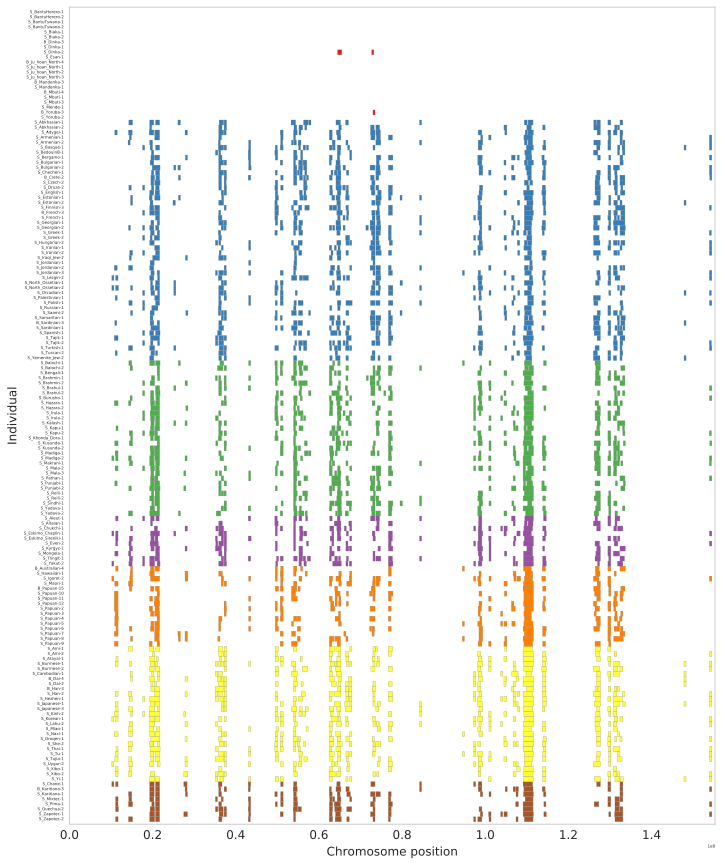

In [26]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord
           .assign(indiv_1 = pandas.Categorical(sweep_coord.indiv_1,
                                                   categories=all_indivduals,
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        plt.yticks(range(len(labs)), reversed(labs))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

#         for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                      facecolor='lightgray', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)

        plt.tight_layout()
        
        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX_clean.pdf"))

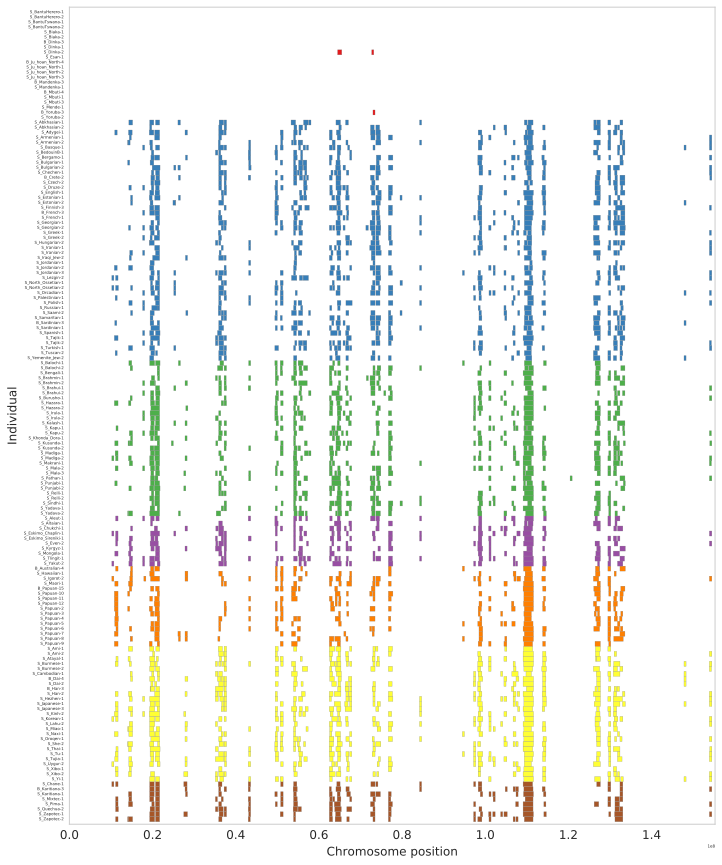

In [27]:
# turn indiv_1 into category with levels including any with no sweeps, and a corresponding int
plot_df = (sweep_coord_af
           .assign(indiv_1 = pandas.Categorical(sweep_coord_af.indiv_1,
                                                   categories=all_indivduals,
                                                   ordered=True))
           .assign(indiv_code = lambda df: df.indiv_1.cat.codes)
          )

with sns.plotting_context('paper', font_scale=0.5):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10,12))
        ax.set_xlim([0, chromosome_lengths['X']])
        ax.set_ylim([-1, len(all_indivduals)])
        labs = pandas.Categorical(all_indivduals,
                           categories=all_indivduals,
                           ordered=True)
        plt.yticks(range(len(labs)), reversed(labs))

        for segm in plot_df.itertuples():            
            y = len(all_indivduals) - segm.indiv_code - 1
            g = ax.add_patch(Rectangle((segm.start, y-0.5), segm.end-segm.start, 1, 
                                        facecolor=region_colors[segm.region_label_1], edgecolor='grey'))

#         for segm in missing_regions.loc[missing_regions.is_missing == True].itertuples():
#             g = ax.add_patch(Rectangle((segm.start, 0), segm.end-segm.start, len(all_indivduals), 
#                      facecolor='lightgray', 
#                      edgecolor=None,
#                      alpha=0.5,
#                      zorder=0))

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
            
        plt.xlabel('Chromosome position', fontsize=12)
        plt.ylabel('Individual', fontsize=12)
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / "swept_male_haplotypes_map_chrX_clean_af.pdf"))

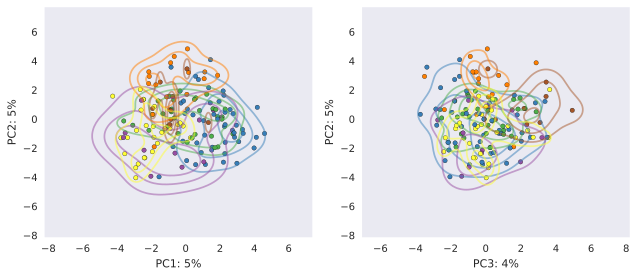

In [22]:
df = (sweep_data.loc[lambda df: df.region_1 != 'Africa', ['indiv_1', 'start', 'swept']]
       .pivot(index='indiv_1', columns='start', values='swept')
      )
colors = [region_colors[individuals[x]['Region']] for x in df.index.values]
mat = df.as_matrix().astype('int')

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(mat)
labels = ["PC{}: {}%".format(i+1, int(round(r*100)), 0) for (i, r) in enumerate(pca.explained_variance_ratio_)]

X = pca.transform(mat)
with sns.plotting_context('notebook'):
    with sns.axes_style("dark"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
        ax1.scatter(X[:, 0], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 0], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax1, n_levels=3, cmap=None, colors=col, alpha=0.5)
        ax1.set_xlabel(labels[0])
        ax1.set_ylabel(labels[1])

        ax2.scatter(X[:, 2], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 2], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax2, n_levels=3, cmap=None, colors=col, alpha=0.5)
        ax2.set_xlabel(labels[2])
        ax2.set_ylabel(labels[1])

        plt.tight_layout()

        plt.savefig(str(figures_dir / 'pca_sweep.pdf'))

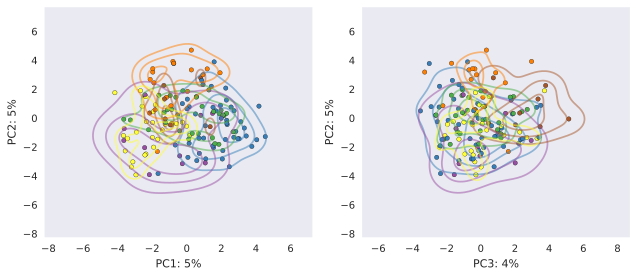

In [23]:
df = (sweep_data.loc[lambda df: df.region_1 != 'Africa', ['indiv_1', 'start', 'swept_af']]
       .pivot(index='indiv_1', columns='start', values='swept_af')
      )
colors = [region_colors[individuals[x]['Region']] for x in df.index.values]
mat = df.as_matrix().astype('int')

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(mat)
labels = ["PC{}: {}%".format(i+1, int(round(r*100)), 0) for (i, r) in enumerate(pca.explained_variance_ratio_)]

X = pca.transform(mat)

with sns.plotting_context('notebook'):
    with sns.axes_style("dark"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
        ax1.scatter(X[:, 0], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 0], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax1, n_levels=3, cmap=None, colors=col, alpha=0.5)
        ax1.set_xlabel(labels[0])
        ax1.set_ylabel(labels[1])

        ax2.scatter(X[:, 2], X[:, 1], c=colors)
        for col, group in DataFrame(dict(x=X[:, 2], y=X[:, 1], color=colors)).groupby('color'):
            sns.kdeplot(group.x, group.y, ax=ax2, n_levels=3, cmap=None, colors=col, alpha=0.5)
        ax2.set_xlabel(labels[2])
        ax2.set_ylabel(labels[1]) ;

        plt.tight_layout()
        
        plt.savefig(str(figures_dir / 'pca_sweep_af.pdf'))

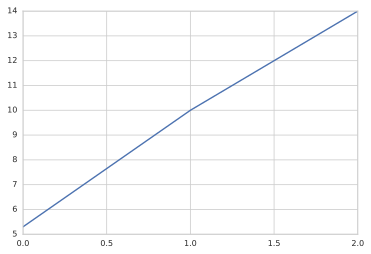

In [24]:
cum_var_exp = numpy.cumsum(numpy.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot(cum_var_exp) ;

In [16]:
# %matplotlib notebook

# from mpl_toolkits.mplot3d import Axes3D


# fig = plt.figure(1, figsize=(7, 7))
# plt.clf()
# ax = Axes3D(fig)#, rect=[0, 0, .95, 1], elev=48, azim=134)

# plt.cla()

# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors)

# ax.w_xaxis.set_ticklabels([])
# ax.w_yaxis.set_ticklabels([])
# ax.w_zaxis.set_ticklabels([])

# # for angle in range(0, 360):
# #     ax.view_init(30, angle)
# #     plt.draw()
# #     plt.pause(.001)
    
# plt.show()